In [1]:
# Base Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Scikit Learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score     # |
from sklearn.model_selection import train_test_split                                    # Train and Test Split
from sklearn.svm import OneClassSVM                                                     # One Class SVM
from sklearn.ensemble import RandomForestClassifier                                     # RFC
from sklearn.linear_model import Lasso                                                  # LASSO
from sklearn.decomposition import PCA                                                   # PCA
from sklearn.feature_selection import f_classif                                         # ANOVA
from skrebate import ReliefF, MultiSURF                                                 # ReliefF, MultiSURF
from sklearn.feature_selection import mutual_info_classif                               # Information Gain
from scipy.stats import pearsonr                                                        # Pearson correlation
from xgboost import XGBClassifier                                                       # XGBoost

In [2]:
# Convert seconds to minutes and seconds
def predict(seconds):
    minutes = seconds // 60
    seconds_remaining = seconds % 60
    return minutes, seconds_remaining

In [3]:
# Execute feature selection
def feature_selection(df, metodo = "rfc", col_timestamp = False, alpha_value = 0.1, n_pca_components=None):
    # Separate features (X) and labels (y)
    if(col_timestamp):
        X = df.drop(['label', 'timestamp'], axis=1)
    else:
        X = df.drop(['label'], axis=1)
    y = df['label']
    
    # Divides the data into training (30%) and testing (70%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=42) # random_state for replication
    
    if(metodo == "rfc"):
        # Train the model
        rf_model = RandomForestClassifier(random_state=24)
        rf_model.fit(X_train, y_train)
        
        # Get features importance
        importances = rf_model.feature_importances_
    elif(metodo == "lasso"):
        # Train the model
        lasso_model = Lasso(alpha = alpha_value, random_state=24, max_iter=10000 )  # O valor de alpha pode ser ajustado
        lasso_model.fit(X_train, y_train)
        
        # Get features importance
        importances = np.abs(lasso_model.coef_)
    elif(metodo == "xgboost"):
        # Train the model
        xgb_model = XGBClassifier(random_state=24)
        xgb_model.fit(X_train, y_train)
        
        # Get features importance
        importances = xgb_model.feature_importances_
    elif metodo == "pca":
        # Apply PCA
        pca = PCA(n_components=n_pca_components)
        X_train_pca = pca.fit_transform(X_train)

        # Get features importance
        importances = np.sum(np.abs(pca.components_), axis=0)
    elif metodo == "anova":
        # Apply ANOVA
        f_values, _ = f_classif(X_train, y_train)

        # Get features importance using F-values
        importances = f_values
    elif metodo == "relieff":
        # Transform to ndarray
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Apply RefiefF
        relief = ReliefF()
        relief.fit(X_train, y_train)
        
        # Get features importance
        importances = relief.feature_importances_

    elif metodo == "multisurf":
        # Transform to ndarray
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Apply MultiSURF
        multi_surf = MultiSURF()
        multi_surf.fit(X_train, y_train)
        
        # Get features importance
        importances = multi_surf.feature_importances_

    elif metodo == "chi2":
        # Get features importance
        importances, _ = chi2_scores, _ = chi2(X_train, y_train)
        
    elif metodo == "ig":
        # Get features importance
        importances = mutual_info_classif(X_train, y_train)

    elif metodo == "pc":
        # Transform to ndarray
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Get features importance
        importances = np.array([pearsonr(X_train[:, i], y_train)[0] for i in range(X_train.shape[1])])

    else:
        print("Error: Invalid Feature Selection Method")
        return
    
    # Build a dataframe
    importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    
    # Sort the dataframe by importance
    importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Return the sorted features
    return importances_df

In [4]:
# Function to execute the experiments
def experiment(df, features, col_timestamp = False, less = False):
    # Remove timestamp column
    if(col_timestamp):
        df = df.drop('timestamp', axis=1)

    # Divide the Training and Test sets
    # We want to evaluate detection over time, so shuffle = False
    # 1/3 of the dataset for training
    X = df[features]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, shuffle=False, random_state=42)

    # Train the model
    clf = OneClassSVM(gamma='auto', kernel='poly', nu=0.05).fit(X_train)
    
    # Test the model
    predictions = clf.predict(X_test)
    
    # Normalizes predictions
    predictions_norm = [0 if i == 1 else 1 for i in predictions]
    
    # Get the metrics
    accuracy = accuracy_score(y_test ,predictions_norm) * 100
    weighted_precision = precision_score(y_test, predictions_norm, average='weighted') * 100
    weighted_recall = recall_score(y_test, predictions_norm, average='weighted') * 100
    weighted_f1_score = f1_score(y_test, predictions_norm, average='weighted') * 100

    # Calculate prediction time
    outlier_indices = np.where(np.array(predictions_norm) == 1)[0]
    cut = int(len(df)*0.33)
    offset = outlier_indices + cut
    maligno = df.loc[offset]
    certo = maligno.loc[maligno["label"] == 1]
    # If at least one malign interval has correctly classified
    if(len(certo) != 0):
        tempo = len(df) - certo.index[0]
        # Result array
        result = [accuracy, weighted_precision, weighted_recall, weighted_f1_score, tempo]
        # Return result
        return result

    # Result array
    result = [accuracy, weighted_precision, weighted_recall, weighted_f1_score, 0]

    # Return result
    return result

In [9]:
# Preparação do ataque : 3601
# Início do ataque : 5282
df = pd.read_csv("wp2/v5.csv")
df

,total.pckts,tcp.pct,udp.pct,http.pct,other.pct,ip.src.unique,ip.dest.unique,eth.src.unique,eth.dest.unique,pkt.length.mean,...,firewall.avg.ttl,firewall.avg.win.size,firewall.count.seq,firewall.count_ACK,firewall.unique.marks,firewall.unique.in.interface,firewall.unique.mac,firewall.tos,firewall.precedence,label
0,1489,79.986568,0.0,20.013432,0.000000,26,26,26,26,171.481531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1500,80.200000,0.0,19.800000,0.000000,26,26,26,26,170.092000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1502,80.093209,0.0,19.906791,0.000000,26,26,26,26,171.183755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1503,80.106454,0.0,19.893546,0.000000,26,26,26,26,170.564205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1490,80.201342,0.0,19.798658,0.000000,26,26,26,26,170.637584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5573,111767,72.758507,0.0,0.000000,27.241493,7,7,6,6,318.233343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5574,118494,72.288048,0.0,0.000000,27.711952,6,6,6,6,320.185123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5575,121090,71.070278,0.0,0.000000,28.929722,6,6,6,6,324.333223,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5576,119000,71.771429,0.0,0.000000,28.228571,6,6,6,6,321.265916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5578 entries, 0 to 5577
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total.pckts                   5578 non-null   int64  
 1   tcp.pct                       5578 non-null   float64
 2   udp.pct                       5578 non-null   float64
 3   http.pct                      5578 non-null   float64
 4   other.pct                     5578 non-null   float64
 5   ip.src.unique                 5578 non-null   int64  
 6   ip.dest.unique                5578 non-null   int64  
 7   eth.src.unique                5578 non-null   int64  
 8   eth.dest.unique               5578 non-null   int64  
 9   pkt.length.mean               5578 non-null   float64
 10  pkt.length.std                5578 non-null   float64
 11  pkt.length.var                5578 non-null   float64
 12  pkt.length.min                5578 non-null   float64
 13  pkt

In [11]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp=False, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/v5_deteccao_{method}_results.csv", index=False)

Method: pc
ttl.tquartil
100.00%


In [12]:
pca_results = pd.read_csv("wp2/resultados/v5_deteccao_pca_results.csv")
anova_results = pd.read_csv("wp2/resultados/v5_deteccao_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/v5_deteccao_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/v5_deteccao_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/v5_deteccao_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/v5_deteccao_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/v5_deteccao_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/v5_deteccao_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/v5_deteccao_rfc_results.csv")

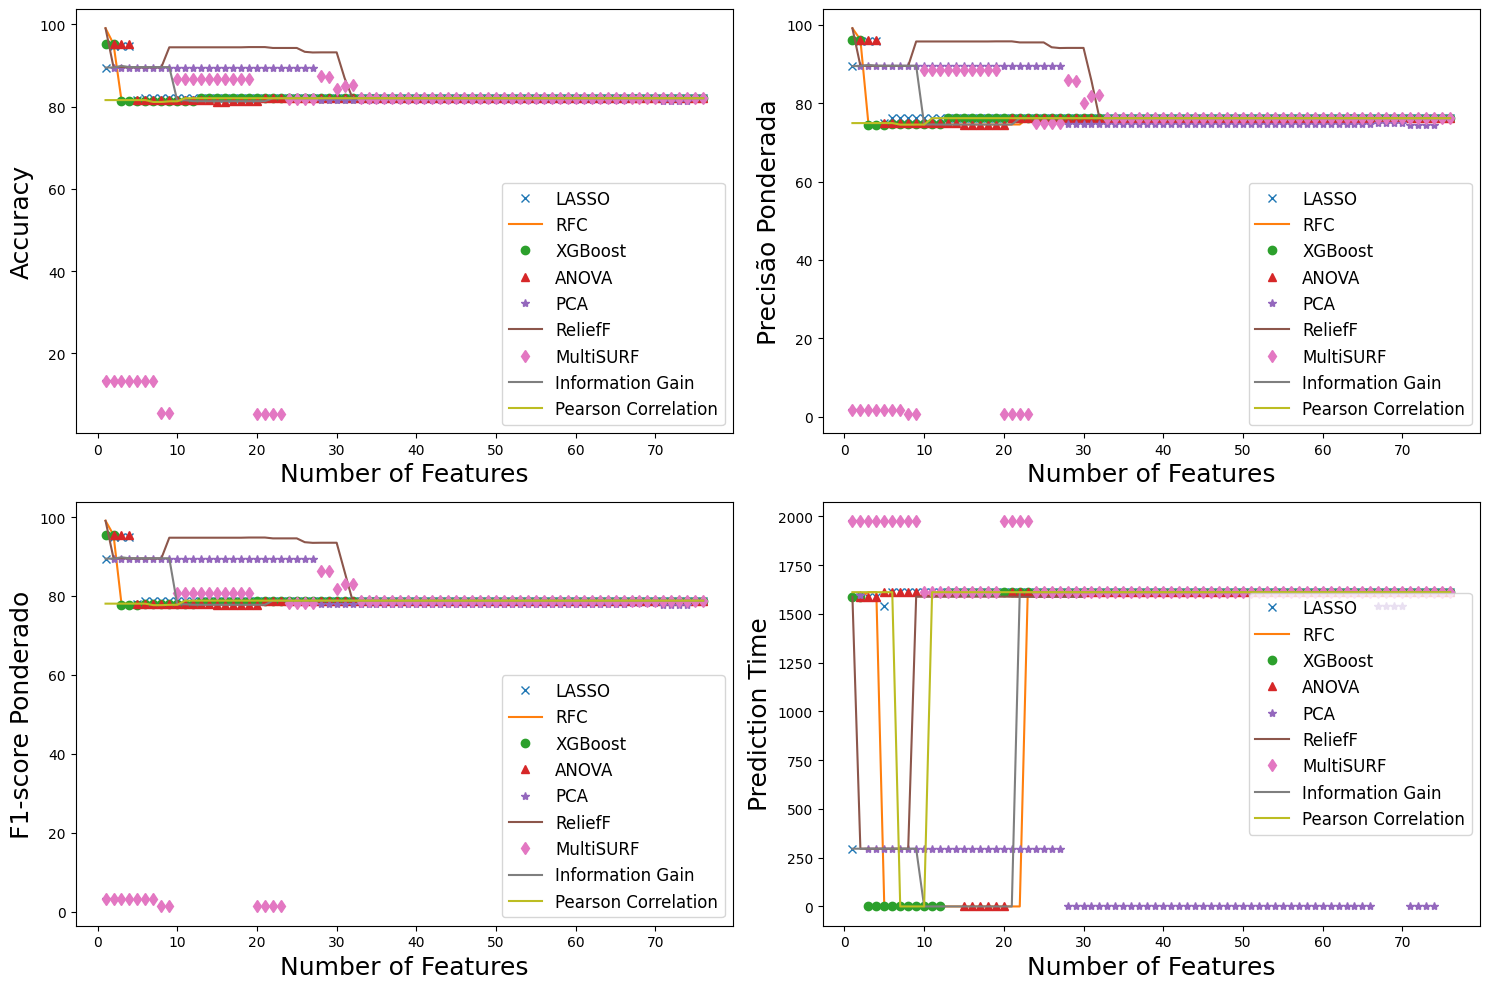

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0, 0], 'accuracy', "Accuracy")
plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1, 1], 'predict_s', "Prediction Time")

plt.tight_layout()

#plt.savefig('.pdf')

plt.show()

In [14]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] #+ row['predict_s']                                     # These conditions can be changed to filter the results
        if combination > max_combination and row['n_features'] < 50 and row['accuracy'] > 75: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features        2.000000
accuracy         89.513109
w_precision      89.424727
w_recall         89.513109
w_f1score        89.467898
predict_s      1599.000000
Name: 1, dtype: float64
Dataset: anova
n_features        1.000000
accuracy         99.063670
w_precision      99.058426
w_recall         99.063670
w_f1score        99.057578
predict_s      1588.000000
Name: 0, dtype: float64
Dataset: multisurf
n_features       28.000000
accuracy         87.506688
w_precision      85.942953
w_recall         87.506688
w_f1score        86.450745
predict_s      1611.000000
Name: 27, dtype: float64
Dataset: lasso
n_features        2.000000
accuracy         94.783307
w_precision      95.887734
w_recall         94.783307
w_f1score        95.074348
predict_s      1588.000000
Name: 1, dtype: float64
Dataset: xgboost
n_features        1.000000
accuracy         95.238095
w_precision      96.150007
w_recall         95.238095
w_f1score        95.479480
predict_s  

In [15]:
df = df.loc[:5281]

In [16]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp=False, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/v5_predicao_{method}_results.csv", index=False)

Method: pc
ttl.tquartil
100.00%


In [17]:
pca_results = pd.read_csv("wp2/resultados/v5_predicao_pca_results.csv")
anova_results = pd.read_csv("wp2/resultados/v5_predicao_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/v5_predicao_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/v5_predicao_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/v5_predicao_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/v5_predicao_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/v5_predicao_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/v5_predicao_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/v5_predicao_rfc_results.csv")

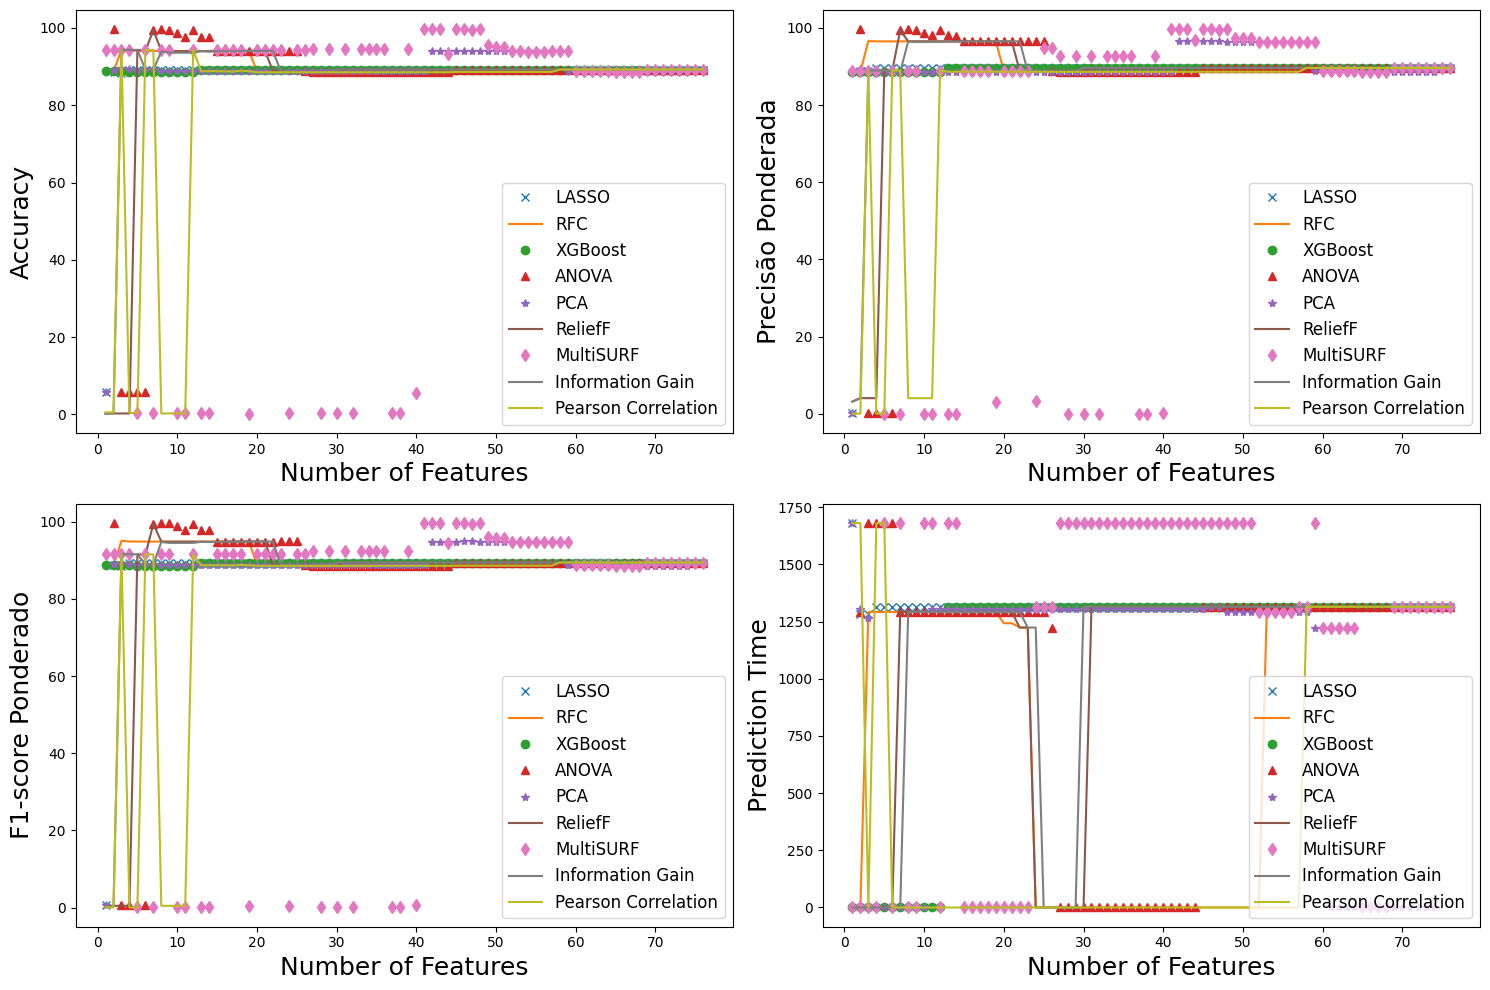

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0, 0], 'accuracy', "Accuracy")
plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1, 1], 'predict_s', "Prediction Time")

plt.tight_layout()

#plt.savefig('.pdf')

plt.show()

In [19]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                     # These conditions can be changed to filter the results
        if combination > max_combination and row['n_features'] < 50 and row['accuracy'] > 75: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features       46.000000
accuracy         94.066120
w_precision      96.645126
w_recall         94.066120
w_f1score        94.901519
predict_s      1315.000000
Name: 45, dtype: float64
Dataset: anova
n_features       45.000000
accuracy         89.234247
w_precision      89.646417
w_recall         89.234247
w_f1score        89.438903
predict_s      1315.000000
Name: 44, dtype: float64
Dataset: multisurf
n_features       41.000000
accuracy         99.660921
w_precision      99.668140
w_recall         99.660921
w_f1score        99.663262
predict_s      1681.000000
Name: 40, dtype: float64
Dataset: lasso
n_features        4.000000
accuracy         89.234247
w_precision      89.646417
w_recall         89.234247
w_f1score        89.438903
predict_s      1315.000000
Name: 3, dtype: float64
Dataset: xgboost
n_features       13.000000
accuracy         89.234247
w_precision      89.646417
w_recall         89.234247
w_f1score        89.438903
predict_s

In [20]:
df = pd.read_csv("wp2/v5_processed_ordptr.csv")
df

,timestamp,total.pckts_entropy,total.pckts_complexity,total.pckts_fisher_shanon,total.pckts_edge_entropy,total.pckts_edge_complexity,total.pckts_edge_fisher_shannon,total.pckts_number_nodes,total.pckts_self_transition,tcp.pct_entropy,...,firewall.tos_self_transition,firewall.precedence_entropy,firewall.precedence_complexity,firewall.precedence_fisher_shanon,firewall.precedence_edge_entropy,firewall.precedence_edge_complexity,firewall.precedence_edge_fisher_shannon,firewall.precedence_number_nodes,firewall.precedence_self_transition,label
0,"[0, 558]",0.990795,0.008893,0.006834,0.967132,0.030602,0.042893,18,0.111712,0.981461,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
1,"[1, 559]",0.990882,0.008818,0.006768,0.967132,0.030602,0.042893,18,0.109910,0.980969,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
2,"[2, 560]",0.991184,0.008541,0.006728,0.967132,0.030602,0.042893,18,0.109910,0.980756,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
3,"[3, 561]",0.991184,0.008541,0.006728,0.967132,0.030602,0.042893,18,0.109910,0.981287,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
4,"[4, 562]",0.991184,0.008541,0.006728,0.948880,0.050098,0.072600,18,0.109910,0.981386,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,"[5015, 5573]",0.994740,0.005085,0.003546,0.960733,0.039983,0.032871,18,0.100901,0.997231,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,1
5016,"[5016, 5574]",0.994716,0.005110,0.003436,0.960733,0.039983,0.032871,18,0.100901,0.997231,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,1
5017,"[5017, 5575]",0.994997,0.004845,0.003350,0.960733,0.039983,0.032871,18,0.100901,0.997497,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,1
5018,"[5018, 5576]",0.994680,0.005146,0.003611,0.960733,0.039983,0.032871,18,0.100901,0.997535,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,1


In [21]:
df.loc[:4723]

,timestamp,total.pckts_entropy,total.pckts_complexity,total.pckts_fisher_shanon,total.pckts_edge_entropy,total.pckts_edge_complexity,total.pckts_edge_fisher_shannon,total.pckts_number_nodes,total.pckts_self_transition,tcp.pct_entropy,...,firewall.tos_self_transition,firewall.precedence_entropy,firewall.precedence_complexity,firewall.precedence_fisher_shanon,firewall.precedence_edge_entropy,firewall.precedence_edge_complexity,firewall.precedence_edge_fisher_shannon,firewall.precedence_number_nodes,firewall.precedence_self_transition,label
0,"[0, 558]",0.990795,0.008893,0.006834,0.967132,0.030602,0.042893,18,0.111712,0.981461,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
1,"[1, 559]",0.990882,0.008818,0.006768,0.967132,0.030602,0.042893,18,0.109910,0.980969,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
2,"[2, 560]",0.991184,0.008541,0.006728,0.967132,0.030602,0.042893,18,0.109910,0.980756,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
3,"[3, 561]",0.991184,0.008541,0.006728,0.967132,0.030602,0.042893,18,0.109910,0.981287,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
4,"[4, 562]",0.991184,0.008541,0.006728,0.948880,0.050098,0.072600,18,0.109910,0.981386,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719,"[4719, 5277]",0.985928,0.013352,0.009388,0.990838,0.009196,0.009471,18,0.097297,0.969527,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
4720,"[4720, 5278]",0.985991,0.013286,0.009461,0.990838,0.009196,0.009471,18,0.097297,0.969527,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
4721,"[4721, 5279]",0.986297,0.012996,0.009211,0.990838,0.009196,0.009471,18,0.097297,0.970084,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0
4722,"[4722, 5280]",0.985966,0.013311,0.009296,0.990838,0.009196,0.009471,18,0.097297,0.969499,...,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,1,1.0,0


In [22]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp=True, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/v5_tpo_deteccao_{method}_results.csv", index=False)

Method: pc
http.othermethods.pct_number_nodes
100.00%


In [23]:
pca_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_pca_results.csv")
anova_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_rfc_results.csv")

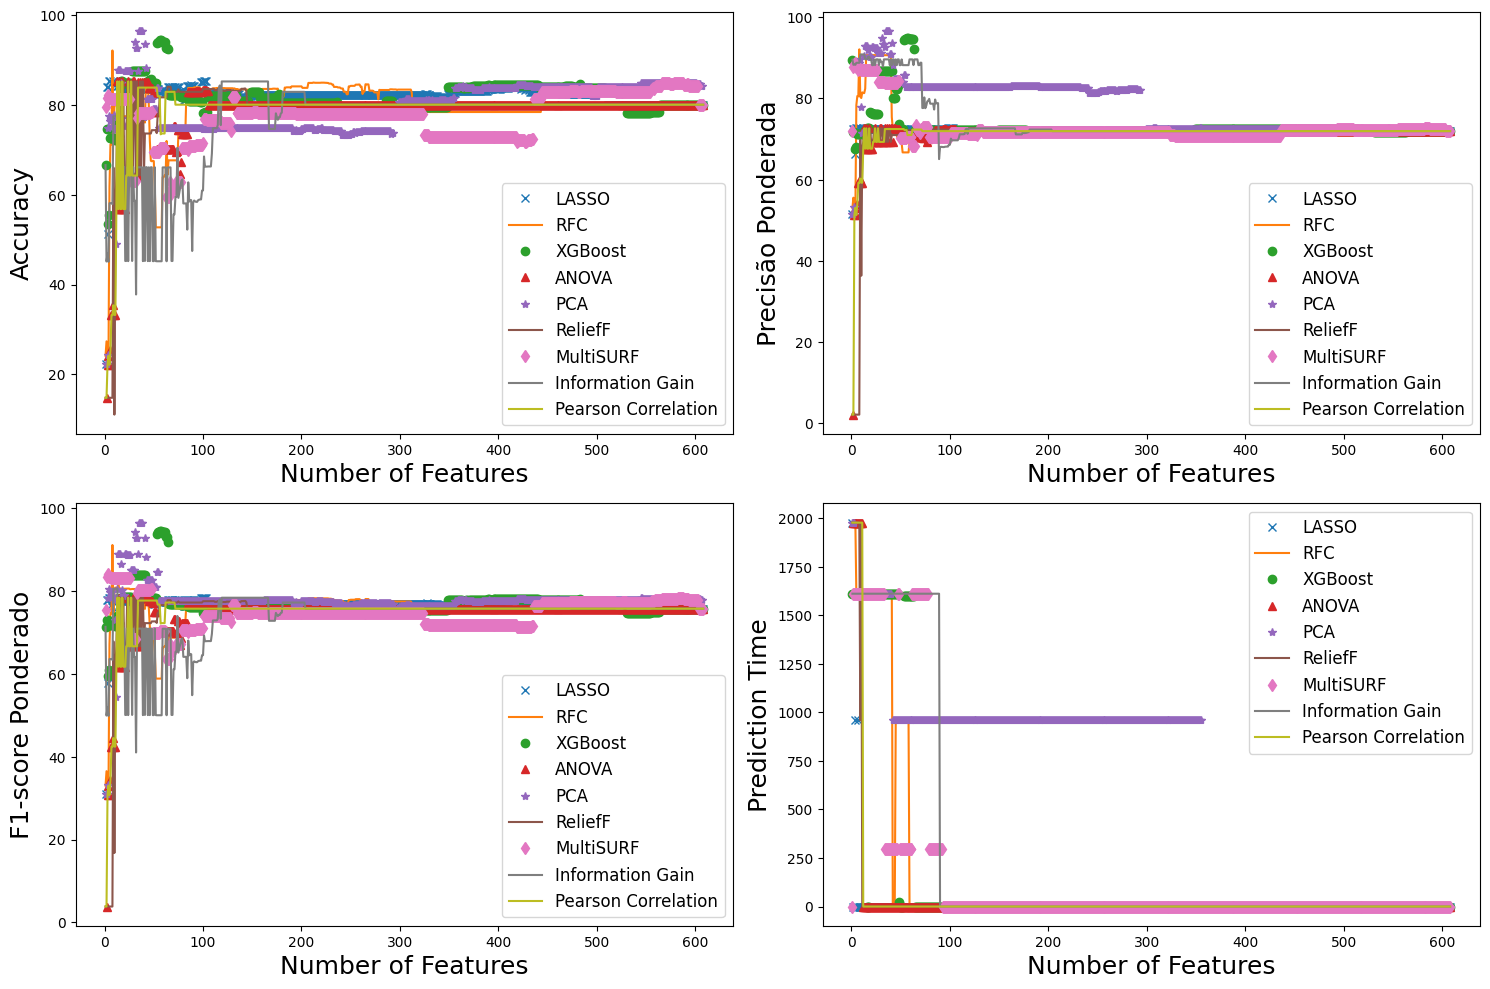

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0, 0], 'accuracy', "Accuracy")
plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1, 1], 'predict_s', "Prediction Time")

plt.tight_layout()

#plt.savefig('.pdf')

plt.show()

In [25]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                     # These conditions can be changed to filter the results
        if combination > max_combination and row['n_features'] < 50 and row['accuracy'] > 75: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features       35.000000
accuracy         96.521998
w_precision      96.655568
w_recall         96.521998
w_f1score        96.570467
predict_s      1611.000000
Name: 34, dtype: float64
Dataset: anova
n_features     13.000000
accuracy       85.225922
w_precision    72.634577
w_recall       85.225922
w_f1score      78.428091
predict_s       0.000000
Name: 12, dtype: float64
Dataset: multisurf
n_features        4.000000
accuracy         82.164090
w_precision      88.648641
w_recall         82.164090
w_f1score        84.108144
predict_s      1611.000000
Name: 3, dtype: float64
Dataset: lasso
n_features       7.000000
accuracy        81.183115
w_precision     72.587748
w_recall        81.183115
w_f1score       76.547486
predict_s      960.000000
Name: 6, dtype: float64
Dataset: xgboost
n_features       28.000000
accuracy         87.455410
w_precision      86.763151
w_recall         87.455410
w_f1score        83.994416
predict_s      1611.000000
N

In [26]:
df = df.loc[:4723]

In [27]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp=True, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/v5_tpo_predicao_{method}_results.csv", index=False)

Method: pc
http.othermethods.pct_number_nodes
100.00%


In [28]:
pca_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_pca_results.csv") 
anova_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_rfc_results.csv")

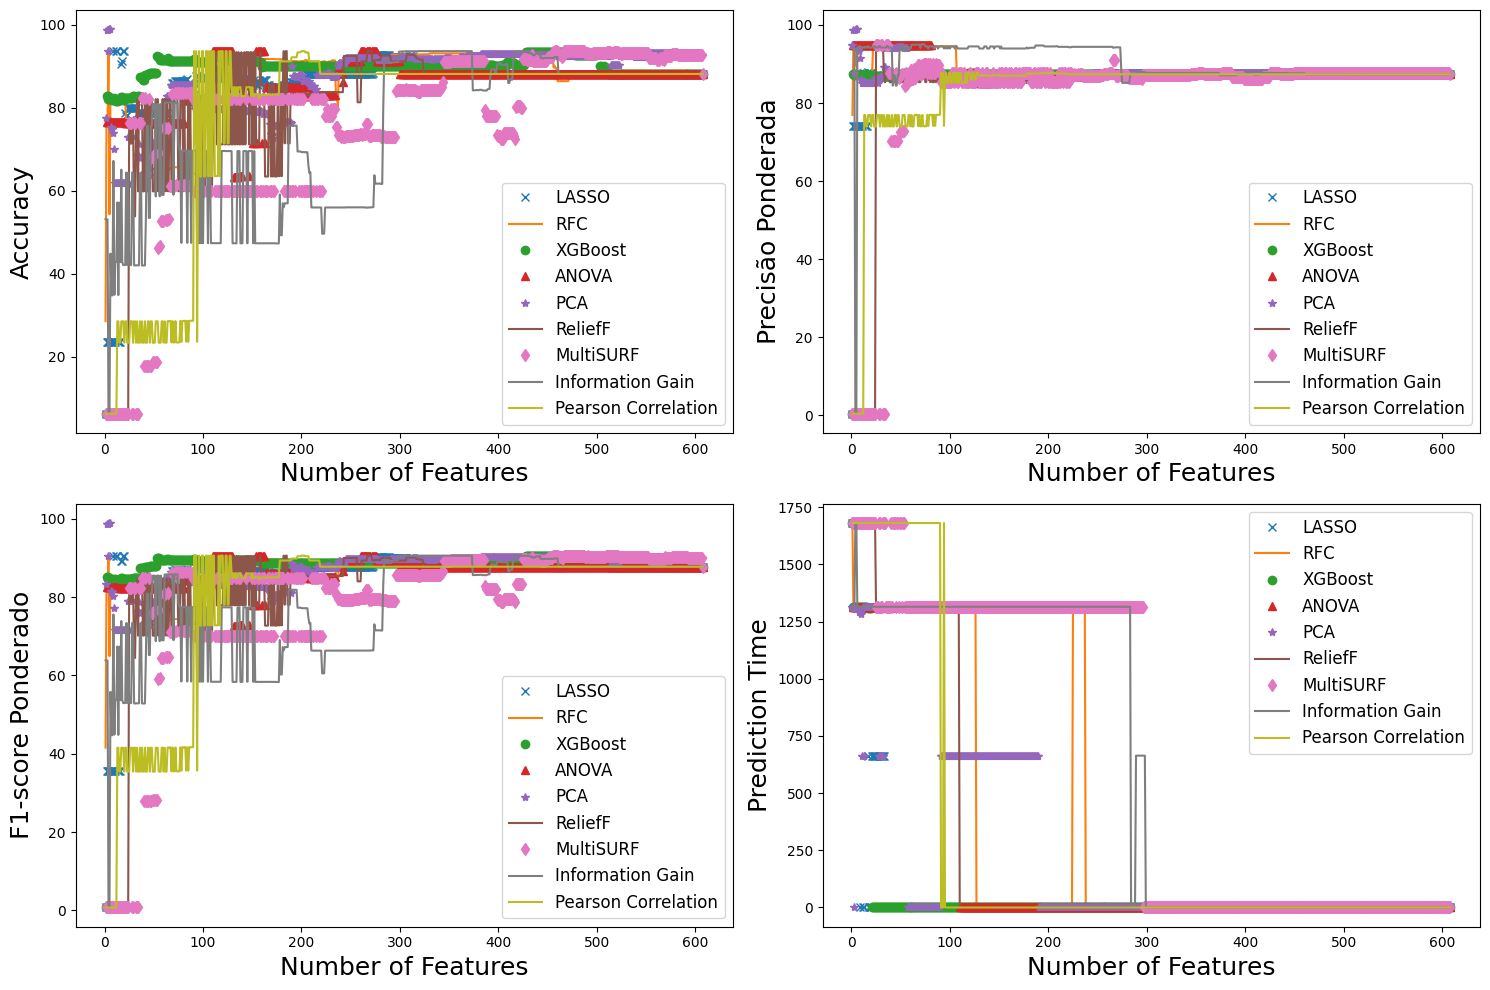

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0, 0], 'accuracy', "Accuracy")
plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1, 1], 'predict_s', "Prediction Time")

plt.tight_layout()

#plt.savefig('.pdf')

plt.show()

In [30]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                      # These conditions can be changed to filter the results
        if combination > max_combination and row['n_features'] < 50 and row['accuracy'] > 75: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features        2.000000
accuracy         98.736576
w_precision      98.742706
w_recall         98.736576
w_f1score        98.739490
predict_s      1308.000000
Name: 1, dtype: float64
Dataset: anova
n_features        6.000000
accuracy         76.753001
w_precision      94.784495
w_recall         76.753001
w_f1score        82.612511
predict_s      1315.000000
Name: 5, dtype: float64
Dataset: multisurf
n_features       38.000000
accuracy         82.312066
w_precision      87.623457
w_recall         82.312066
w_f1score        84.840581
predict_s      1315.000000
Name: 37, dtype: float64
Dataset: lasso
n_features      17.000000
accuracy        90.492735
w_precision     87.853304
w_recall        90.492735
w_f1score       89.135430
predict_s      664.000000
Name: 16, dtype: float64
Dataset: xgboost
n_features        2.000000
accuracy         82.880606
w_precision      87.313175
w_recall         82.880606
w_f1score        85.023239
predict_s      1

In [31]:
df = pd.read_csv('wp2/v5_processed_ordptr_5percent.csv')

In [32]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp=True, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/v5_tpo_deteccao_5p_{method}_results.csv", index=False)

Method: pc
tcp.seq.entropy_number_nodes
100.00%


In [33]:
pca_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_pca_results.csv") 
anova_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/v5_tpo_deteccao_5p_rfc_results.csv")

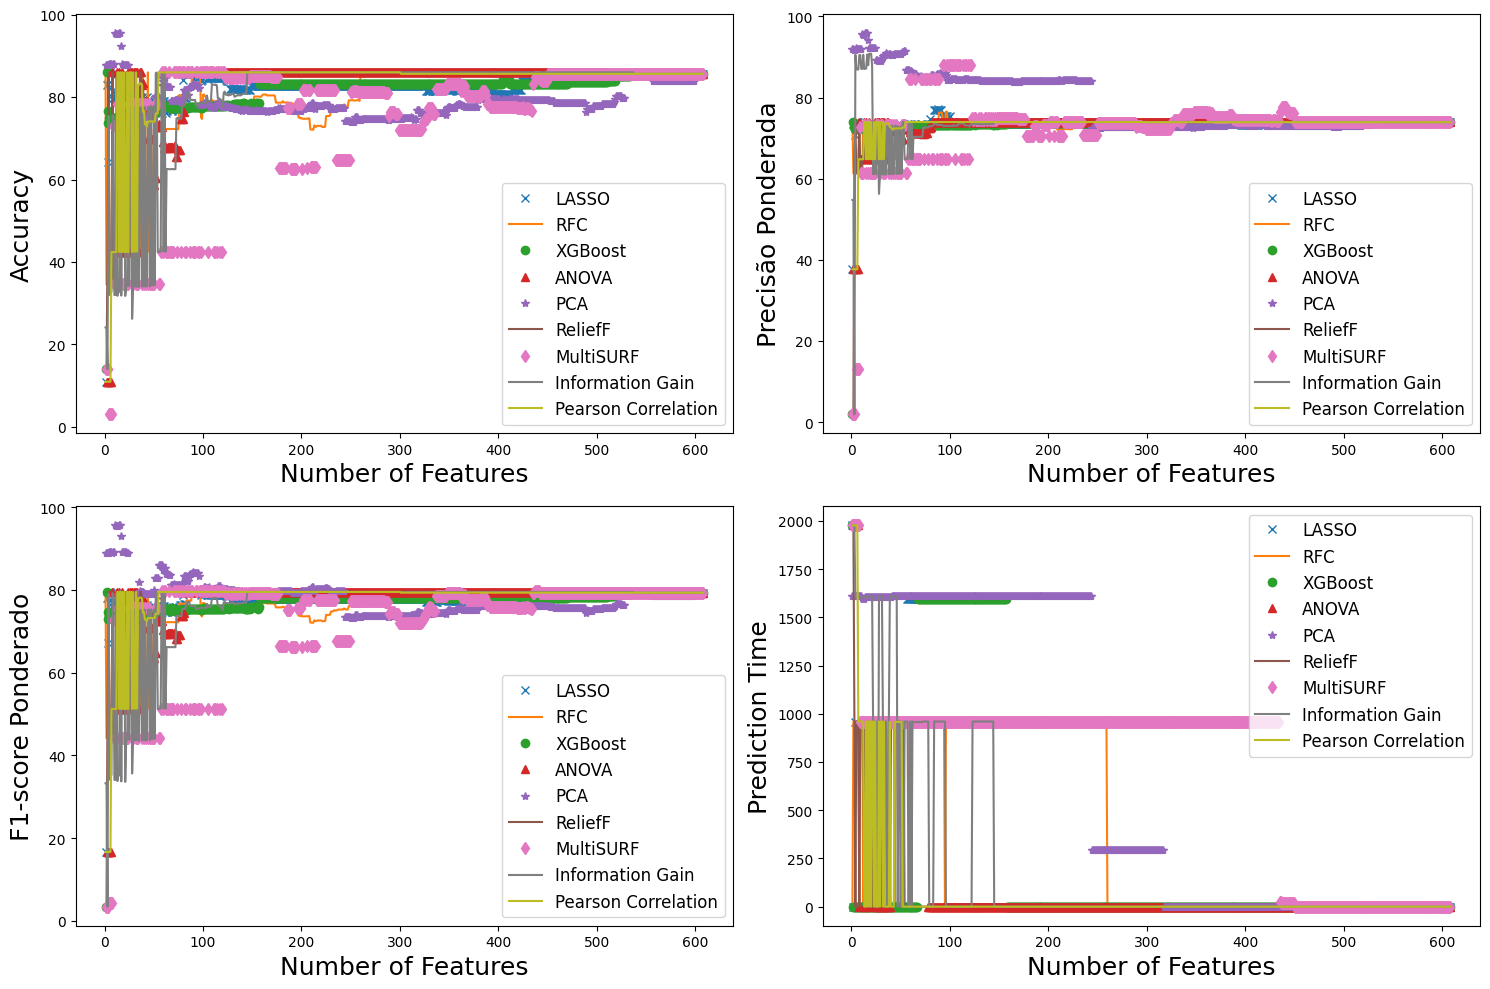

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0, 0], 'accuracy', "Accuracy")
plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1, 1], 'predict_s', "Prediction Time")

plt.tight_layout()

#plt.savefig('.pdf')

plt.show()

In [35]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                      # These conditions can be changed to filter the results
        if combination > max_combination and row['n_features'] < 50 and row['accuracy'] > 75: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features       16.000000
accuracy         95.494227
w_precision      95.904790
w_recall         95.494227
w_f1score        95.625860
predict_s      1608.000000
Name: 15, dtype: float64
Dataset: anova
n_features      42.000000
accuracy        79.048155
w_precision     73.141328
w_recall        79.048155
w_f1score       75.974295
predict_s      957.000000
Name: 41, dtype: float64
Dataset: multisurf
n_features      13.000000
accuracy        78.315967
w_precision     73.169735
w_recall        78.315967
w_f1score       75.643769
predict_s      959.000000
Name: 12, dtype: float64
Dataset: lasso
n_features      37.000000
accuracy        79.752182
w_precision     73.402682
w_recall        79.752182
w_f1score       76.422919
predict_s      960.000000
Name: 36, dtype: float64
Dataset: xgboost
n_features      2.000000
accuracy       86.003943
w_precision    73.966781
w_recall       86.003943
w_f1score      79.532488
predict_s       0.000000
Name: 1, dt

In [52]:
df = df.loc[:5002]

In [53]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    print('Feature Selection Method:', method)
    features = feature_selection(df, method, col_timestamp=True, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/v5_tpo_predicao_5p_{method}_results.csv", index=False)

Method: pc
tcp.seq.entropy_number_nodes
100.00%


In [88]:
pca_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_pca_results.csv") 
anova_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/v5_tpo_predicao_5p_rfc_results.csv")

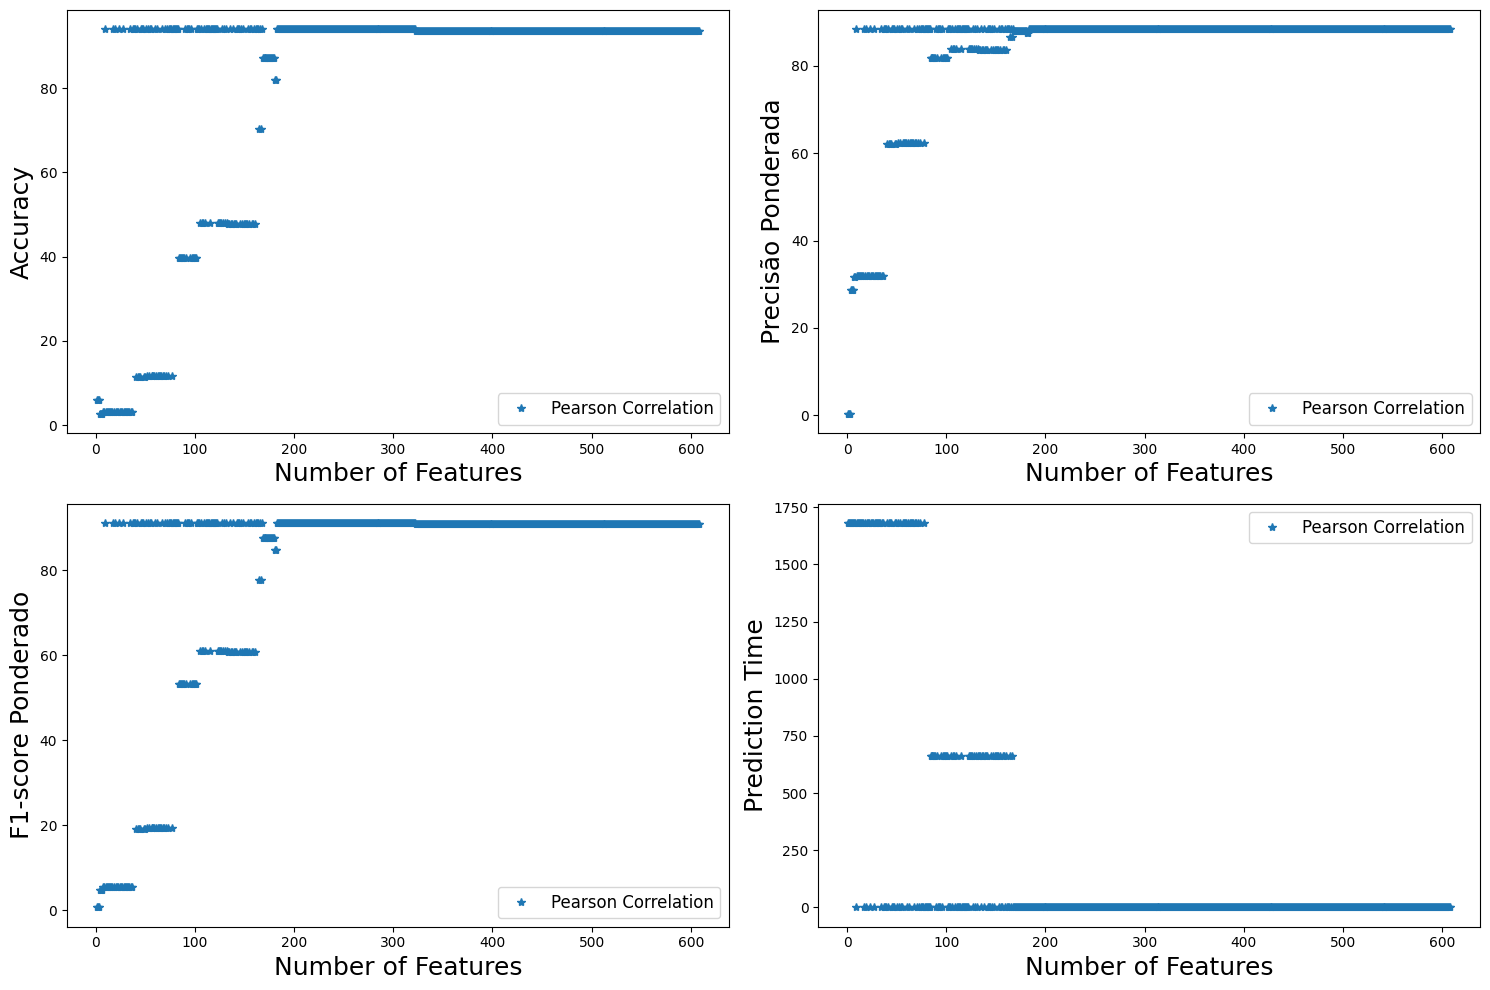

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

def plot_comparison(ax, column_name, ylabel):
    #ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    #ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    #ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    #ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    #ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    #ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    #ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    #ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation', marker='*', linestyle='None')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0, 0], 'accuracy', "Accuracy")
plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1, 1], 'predict_s', "Prediction Time")

plt.tight_layout()

#plt.savefig('.pdf')

plt.show()

In [92]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                      # These conditions can be changed to filter the results
        if combination > max_combination and row['accuracy'] > 75: #and row['predict_s'] > 0: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features        7.000000
accuracy         96.242171
w_precision      97.400471
w_recall         96.242171
w_f1score        96.596834
predict_s      1308.000000
Name: 6, dtype: float64
Dataset: anova
n_features     20.000000
accuracy       94.005368
w_precision    88.370093
w_recall       94.005368
w_f1score      91.100667
predict_s       0.000000
Name: 19, dtype: float64
Dataset: multisurf
n_features       12.000000
accuracy         80.882792
w_precision      95.313105
w_recall         80.882792
w_f1score        85.665254
predict_s      1314.000000
Name: 11, dtype: float64
Dataset: lasso
n_features      9.000000
accuracy       94.005368
w_precision    88.370093
w_recall       94.005368
w_f1score      91.100667
predict_s       0.000000
Name: 8, dtype: float64
Dataset: xgboost
n_features       37.000000
accuracy         87.354608
w_precision      88.329716
w_recall         87.354608
w_f1score        87.837967
predict_s      1681.000000
Name: 3

In [91]:
predict(1681)

(28, 1)

In [32]:
v5 = pd.read_csv("wp2/v5.csv")
v5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5578 entries, 0 to 5577
Data columns (total 77 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total.pckts                   5578 non-null   int64  
 1   tcp.pct                       5578 non-null   float64
 2   udp.pct                       5578 non-null   float64
 3   http.pct                      5578 non-null   float64
 4   other.pct                     5578 non-null   float64
 5   ip.src.unique                 5578 non-null   int64  
 6   ip.dest.unique                5578 non-null   int64  
 7   eth.src.unique                5578 non-null   int64  
 8   eth.dest.unique               5578 non-null   int64  
 9   pkt.length.mean               5578 non-null   float64
 10  pkt.length.std                5578 non-null   float64
 11  pkt.length.var                5578 non-null   float64
 12  pkt.length.min                5578 non-null   float64
 13  pkt

In [33]:
df = pd.read_csv('wp2/v5_processed_ordptr_5percent.csv')

In [36]:
df = df.loc[:5002]

In [68]:
df1 = df[df.columns[1:401]].copy()
df2 = df[df.columns[401:481]].copy()
df3 = df[df.columns[481:-1]].copy()

df1['label'] = df['label'].copy()
df2['label'] = df['label'].copy()
df3['label'] = df['label'].copy()


In [73]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    print('Feature Selection Method:', method)
    features = feature_selection(df1, method, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df1, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/only_traffic_tpo_{method}_results.csv", index=False)

Method: pc
tcp.seq.entropy_number_nodes
100.00%


In [74]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    print('Feature Selection Method:', method)
    features = feature_selection(df2, method, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df2, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/only_apachelogs_tpo_{method}_results.csv", index=False)

Method: pc
apache.nonget.count_fisher_shanon
100.00%


In [75]:
methods = ["rfc",
           "lasso", 
           "xgboost", 
           "anova", 
           "pca", 
           'relieff', 
           'multisurf', 
           'ig', 
           'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    print('Feature Selection Method:', method)
    features = feature_selection(df3, method, alpha_value=1)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df3, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"wp2/resultados/only_firewalllogs_tpo_{method}_results.csv", index=False)

Method: pc
firewall.precedence_self_transition
100.00%


In [101]:
pca_results = pd.read_csv("wp2/resultados/only_traffic_tpo_pca_results.csv") 
anova_results = pd.read_csv("wp2/resultados/only_traffic_tpo_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/only_traffic_tpo_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/only_traffic_tpo_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/only_traffic_tpo_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/only_traffic_tpo_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/only_traffic_tpo_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/only_traffic_tpo_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/only_traffic_tpo_rfc_results.csv")

In [102]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                      # These conditions can be changed to filter the results
        if combination > max_combination and row['accuracy'] > 75: #and row['predict_s'] > 0: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features       10.000000
accuracy         96.182523
w_precision      97.349975
w_recall         96.182523
w_f1score        96.542815
predict_s      1307.000000
Name: 9, dtype: float64
Dataset: anova
n_features      91.000000
accuracy        84.580972
w_precision     87.829467
w_recall        84.580972
w_f1score       86.173163
predict_s      661.000000
Name: 90, dtype: float64
Dataset: multisurf
n_features        5.000000
accuracy         91.529973
w_precision      89.272418
w_recall         91.529973
w_f1score        90.334047
predict_s      1291.000000
Name: 4, dtype: float64
Dataset: lasso
n_features      9.000000
accuracy       94.005368
w_precision    88.370093
w_recall       94.005368
w_f1score      91.100667
predict_s       0.000000
Name: 8, dtype: float64
Dataset: xgboost
n_features       30.000000
accuracy         80.614375
w_precision      90.686054
w_recall         80.614375
w_f1score        84.834275
predict_s      1681.000000
Na

In [99]:
predict(664)

(11, 4)

In [103]:
pca_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_pca_results.csv") 
anova_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/only_apachelogs_tpo_rfc_results.csv")

In [104]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                      # These conditions can be changed to filter the results
        if combination > max_combination and row['accuracy'] > 75 and row['predict_s'] > 0: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features       71.000000
accuracy         89.889651
w_precision      88.823694
w_recall         89.889651
w_f1score        89.348183
predict_s      1302.000000
Name: 70, dtype: float64
Dataset: anova
n_features       70.000000
accuracy         91.351029
w_precision      88.949198
w_recall         91.351029
w_f1score        90.094754
predict_s      1302.000000
Name: 69, dtype: float64
Dataset: multisurf
n_features       65.000000
accuracy         90.873844
w_precision      89.356761
w_recall         90.873844
w_f1score        90.086195
predict_s      1315.000000
Name: 64, dtype: float64
Dataset: lasso
n_features       40.000000
accuracy         90.724724
w_precision      88.830267
w_recall         90.724724
w_f1score        89.748793
predict_s      1302.000000
Name: 39, dtype: float64
Dataset: xgboost
n_features       24.000000
accuracy         91.679093
w_precision      88.948494
w_recall         91.679093
w_f1score        90.239486
predict_

In [109]:
predict(1302)

(21, 42)

In [110]:
pca_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_pca_results.csv") 
anova_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_anova_results.csv")
multisurf_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_multisurf_results.csv")
lasso_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_lasso_results.csv")
xgboost_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_xgboost_results.csv")
ig_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_ig_results.csv")
pc_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_pc_results.csv")
relieff_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_relieff_results.csv")
rfc_results = pd.read_csv("wp2/resultados/only_firewalllogs_tpo_rfc_results.csv")

In [112]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['accuracy'] + row['predict_s']                                      # These conditions can be changed to filter the results
        if combination > max_combination and row['accuracy'] > 75:# and row['predict_s'] > 0: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features       65.000000
accuracy         93.856248
w_precision      89.242774
w_recall         93.856248
w_f1score        91.082845
predict_s      1313.000000
Name: 64, dtype: float64
Dataset: anova
n_features       18.000000
accuracy         88.517745
w_precision      95.801894
w_recall         88.517745
w_f1score        90.914187
predict_s      1313.000000
Name: 17, dtype: float64
Dataset: multisurf
n_features     15.000000
accuracy       94.005368
w_precision    88.370093
w_recall       94.005368
w_f1score      91.100667
predict_s       0.000000
Name: 14, dtype: float64
Dataset: lasso
n_features       36.000000
accuracy         94.035192
w_precision      94.391088
w_recall         94.035192
w_f1score        91.174027
predict_s      1313.000000
Name: 35, dtype: float64
Dataset: xgboost
n_features       40.000000
accuracy         94.035192
w_precision      94.391088
w_recall         94.035192
w_f1score        91.174027
predict_s      1313.

In [113]:
predict(1313)

(21, 53)